<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/MNIST_beta1_noreg_l10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Defining the model**

In [66]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import matplotlib.animation as animation


In [29]:
input_size = (14,14,1)
latent_dim = 10
batch_size = 64


In [30]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]         #the shape of the data is (count, ht, wd)
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)     # we are adding the channel axis manually
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

print(img_train.shape)
print(img_valid.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [31]:
img_train = layers.Resizing(14, 14, interpolation="bilinear")(img_train)
img_valid = layers.Resizing(14, 14, interpolation="bilinear")(img_valid)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)


(60000, 14, 14, 1)
(10000, 14, 14, 1)


In [32]:
l2_reg = keras.regularizers.L2(l2=0.001)

In [33]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(10, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)    # with strides=None this defaults to pool_size
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(30, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(50, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(2*latent_dim)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 14, 14, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 13, 13, 10)           50        ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 10)             0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 re_lu_10 (ReLU)             (None, 7, 7, 10)             0         ['max_pooling2d_4[0][0]'

In [35]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x
                  )
x = layers.Dense(30)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(50)(x)
# = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,50))(x)

x = layers.Conv2DTranspose(30, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(20, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(10, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_8 (Dense)             (None, 20)                220       
                                                                 
 re_lu_20 (ReLU)             (None, 20)                0         
                                                                 
 dense_9 (Dense)             (None, 30)                630       
                                                                 
 re_lu_21 (ReLU)             (None, 30)                0         
                                                                 
 dense_10 (Dense)            (None, 50)                1550      
                                                                 
 re_lu_22 (ReLU)             (None, 50)                0   

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [36]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 10),              8770      
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 decoder (Functional)        (None, 14, 14, 1)         11701     
                                                                 
Total params: 20471 (79.96 KB)
Trainable params: 20471 (79.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We shall define the loss function now, it's made of the reconstruction loss that tries to ensure repoducibility of the data, and the KL divergence loss that tries to ensure that the learned (approximate) posterior is close to the true posterior.

We shall keep a relative weight beta between the two terms in the total loss as a hyperparameter. We may want to investigate the effects of varying this hyperparameter eventually.

In [37]:
beta = 1  # we shall vary this later

def vae_loss(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [38]:
#lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000000, decay_rate=0.99, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.001)
VAE.compile(optimizer=optim,loss=vae_loss)

# **Running up to 15 epochs**

In [39]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)


Epoch 1/15
938/938 [==============================] - 17s 16ms/step - loss: 56.0754 - val_loss: 50.5610
Epoch 2/15
938/938 [==============================] - 15s 16ms/step - loss: 49.8578 - val_loss: 49.3655
Epoch 3/15
938/938 [==============================] - 16s 17ms/step - loss: 49.1569 - val_loss: 48.8780
Epoch 4/15
938/938 [==============================] - 16s 17ms/step - loss: 48.7694 - val_loss: 48.4950
Epoch 5/15
938/938 [==============================] - 14s 15ms/step - loss: 48.3445 - val_loss: 47.8986
Epoch 6/15
938/938 [==============================] - 15s 16ms/step - loss: 47.0055 - val_loss: 46.4549
Epoch 7/15
938/938 [==============================] - 15s 16ms/step - loss: 46.3268 - val_loss: 46.2464
Epoch 8/15
938/938 [==============================] - 15s 16ms/step - loss: 45.9272 - val_loss: 45.9136
Epoch 9/15
938/938 [==============================] - 15s 16ms/step - loss: 45.6785 - val_loss: 45.8637
Epoch 10/15
938/938 [==============================] - 16s 17ms/

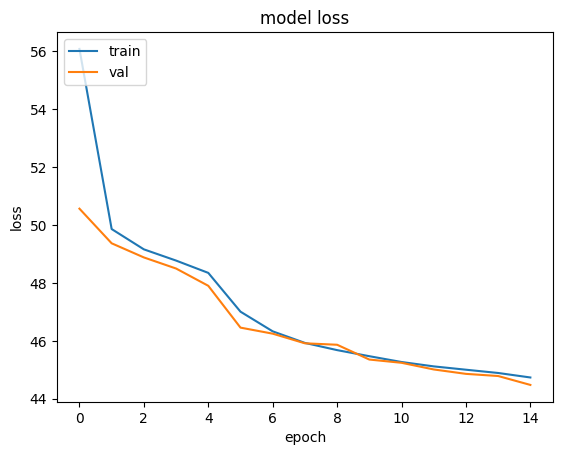

In [40]:
plt.plot(history.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model is still undertrained, which is a little strange considering there's no regularisation in the encoder/decoder, probably has to do with beta being 1, might need to lower it to overtrain.

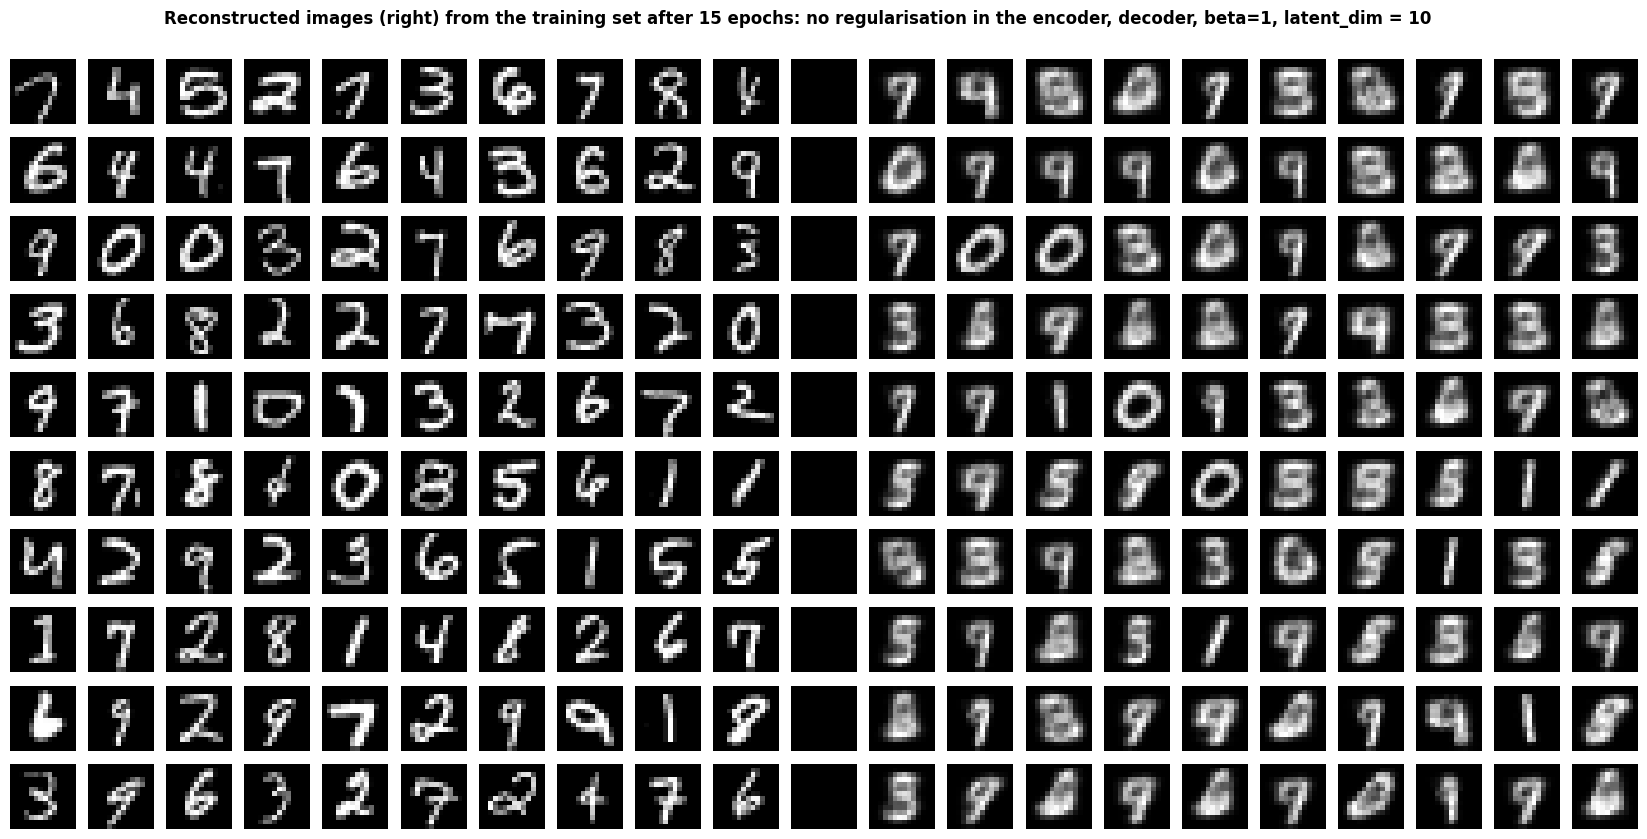

In [41]:
np.random.seed(111)

tr_tg_indices = np.random.randint(0,60000,size = 100)
img_train_sample = tf.convert_to_tensor(np.array(img_train)[tr_tg_indices])
_,_,z_train_sample = encoder(img_train_sample)
img_recon_train = decoder(z_train_sample)

digits_train_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_train_recon.suptitle('Reconstructed images (right) from the training set after 15 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_train_recon.tight_layout()

for i in range(210):
  digits_train_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_train[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')




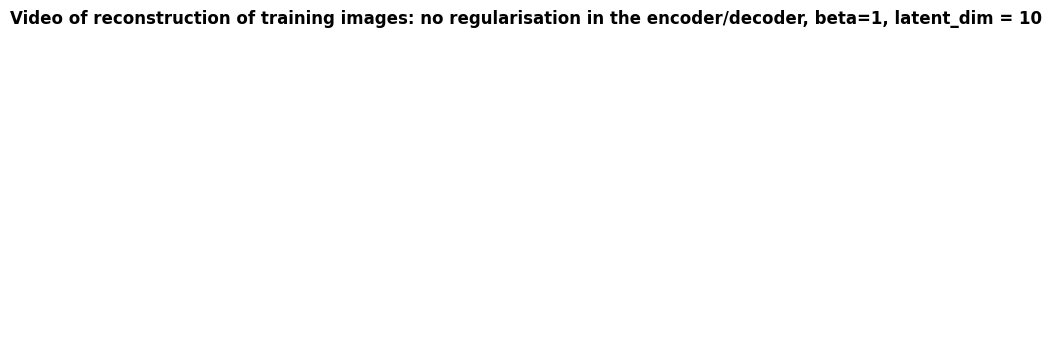

In [42]:
# colab doesn't display the mp4 video

concat_train = tf.concat([img_train_sample, img_recon_train],2)     # to put the original image and the reconstruction next to each other into a (14,28,1) image

frames = []

concat_recon_vid = plt.figure(figsize=(3,6))
plt.axis('off')
concat_recon_vid.suptitle('Video of reconstruction of training images: no regularisation in the encoder/decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

for i in range(25):
    frames.append([plt.imshow(concat_train[i], animated=True)])

vid = animation.ArtistAnimation(concat_recon_vid, frames, interval=50, blit=True,
                                repeat_delay=1000)
# vid.save('recon_train_vid.mp4')
plt.show()


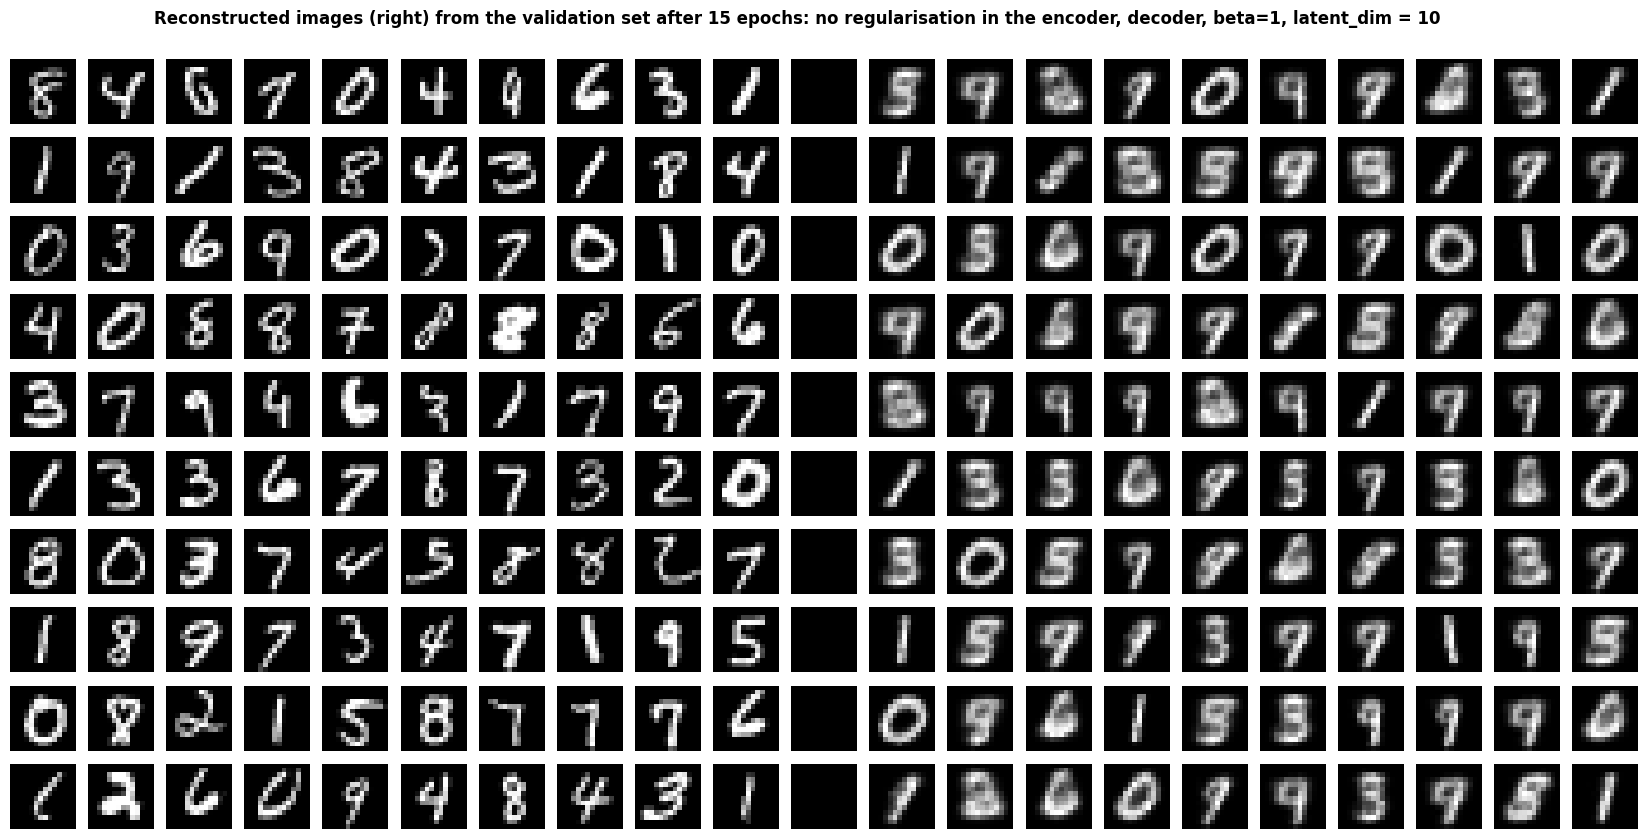

In [43]:
np.random.seed(14)

va_tg_indices = np.random.randint(0,10000,size = 100)
img_valid_sample = tf.convert_to_tensor(np.array(img_valid)[va_tg_indices])
_,_,z_valid_sample = encoder(img_valid_sample)
img_recon_valid = decoder(z_valid_sample)

digits_valid_recon = plt.figure(figsize=(21,10))

digits_valid_recon.suptitle('Reconstructed images (right) from the validation set after 15 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_valid_recon.tight_layout()

for i in range(210):
  digits_valid_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_valid[va_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_valid[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')


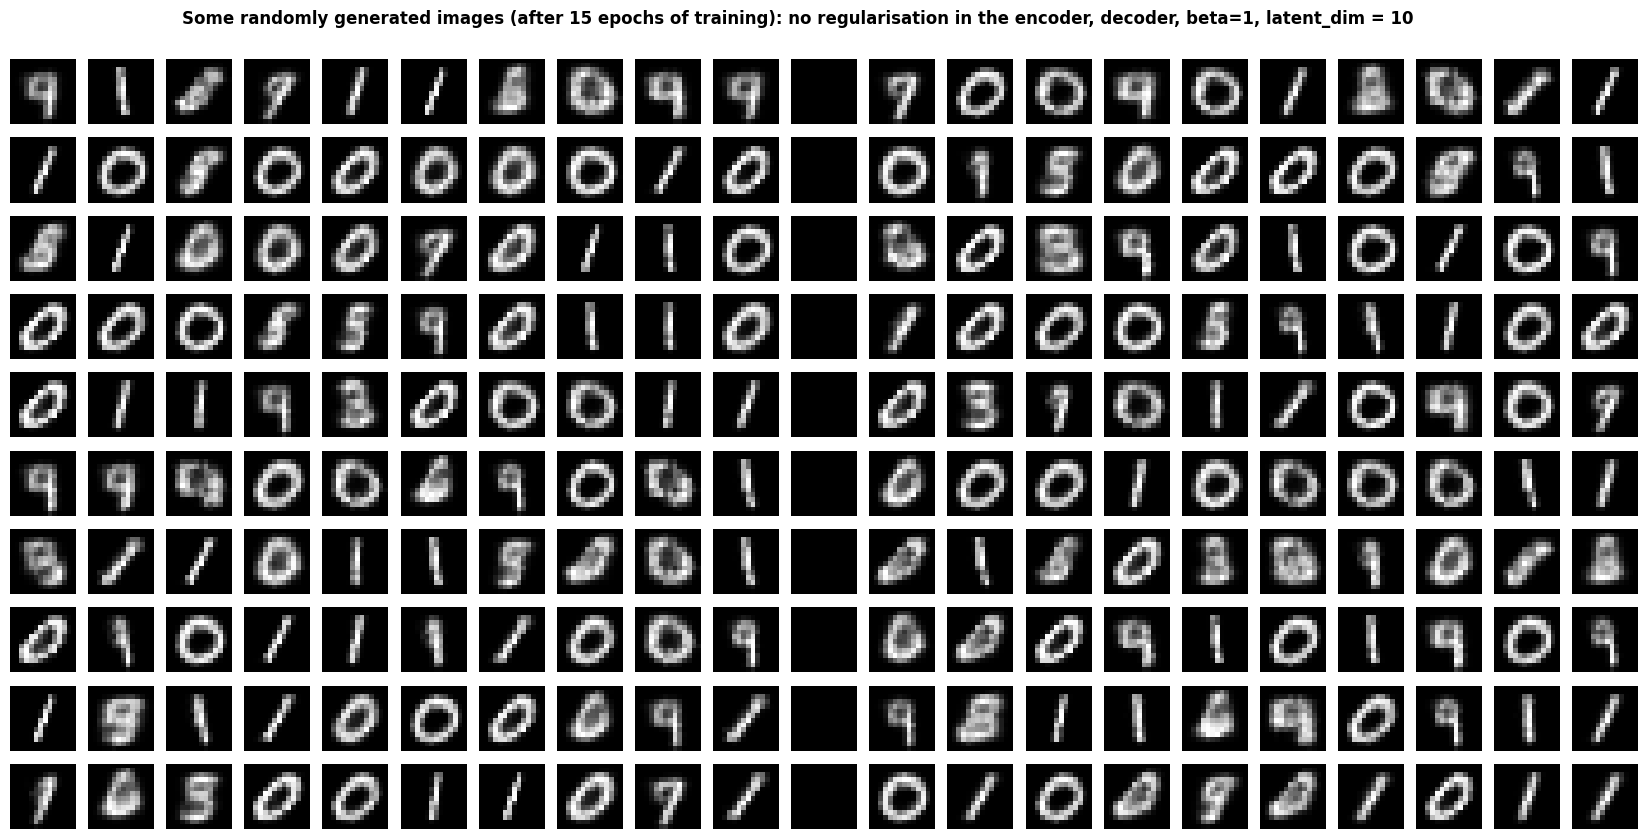

In [44]:
np.random.seed(100)

min_train = min(K.flatten(z_train_sample))
max_train = max(K.flatten(z_train_sample))

min_valid = min(K.flatten(z_valid_sample))
max_valid = max(K.flatten(z_valid_sample))



z_rand_train = tf.convert_to_tensor(min_train + (max_train-min_train)*np.random.random((100,10)))
z_rand_valid = tf.convert_to_tensor(min_valid + (max_valid-min_valid)*np.random.random((100,10)))

img_rand_recon_tr = decoder(z_rand_train)
img_rand_recon_va = decoder(z_rand_valid)

digits_rand_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_rand_recon.suptitle('Some randomly generated images (after 15 epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


for i in range(210):
  digits_rand_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_rand_recon_tr[j*10 + (i%21)]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_rand_recon_va[j*10 + (i%21) - 12]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# **Running further to try and overtrain**

In [45]:
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=25, steps_per_epoch=None)      #running further from where we left off at 15 epochs


Epoch 1/25
938/938 [==============================] - 15s 16ms/step - loss: 44.5011 - val_loss: 44.3816
Epoch 2/25
938/938 [==============================] - 16s 17ms/step - loss: 44.2982 - val_loss: 44.1428
Epoch 3/25
938/938 [==============================] - 14s 15ms/step - loss: 44.0188 - val_loss: 44.0401
Epoch 4/25
938/938 [==============================] - 15s 16ms/step - loss: 43.8251 - val_loss: 43.7173
Epoch 5/25
938/938 [==============================] - 16s 17ms/step - loss: 43.6621 - val_loss: 43.6742
Epoch 6/25
938/938 [==============================] - 15s 16ms/step - loss: 43.5227 - val_loss: 43.5118
Epoch 7/25
938/938 [==============================] - 15s 16ms/step - loss: 43.4063 - val_loss: 43.3205
Epoch 8/25
938/938 [==============================] - 16s 17ms/step - loss: 43.3089 - val_loss: 43.3685
Epoch 9/25
938/938 [==============================] - 15s 16ms/step - loss: 43.2564 - val_loss: 43.2136
Epoch 10/25
938/938 [==============================] - 15s 16ms/

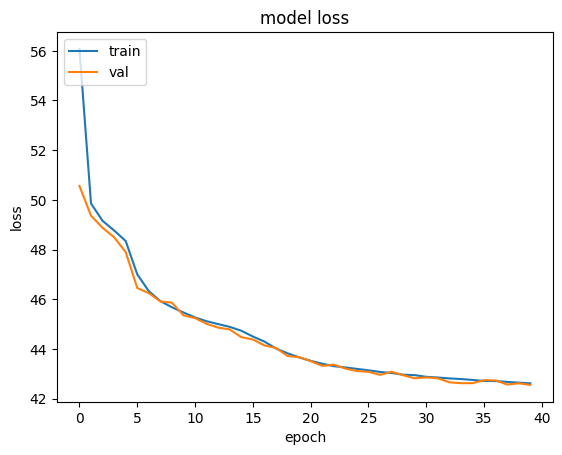

In [46]:
plt.plot(history.history['loss'] + history2.history['loss'] )         # we want to plot the enture learning history so far
plt.plot(history.history['val_loss'] + history2.history['val_loss'] )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

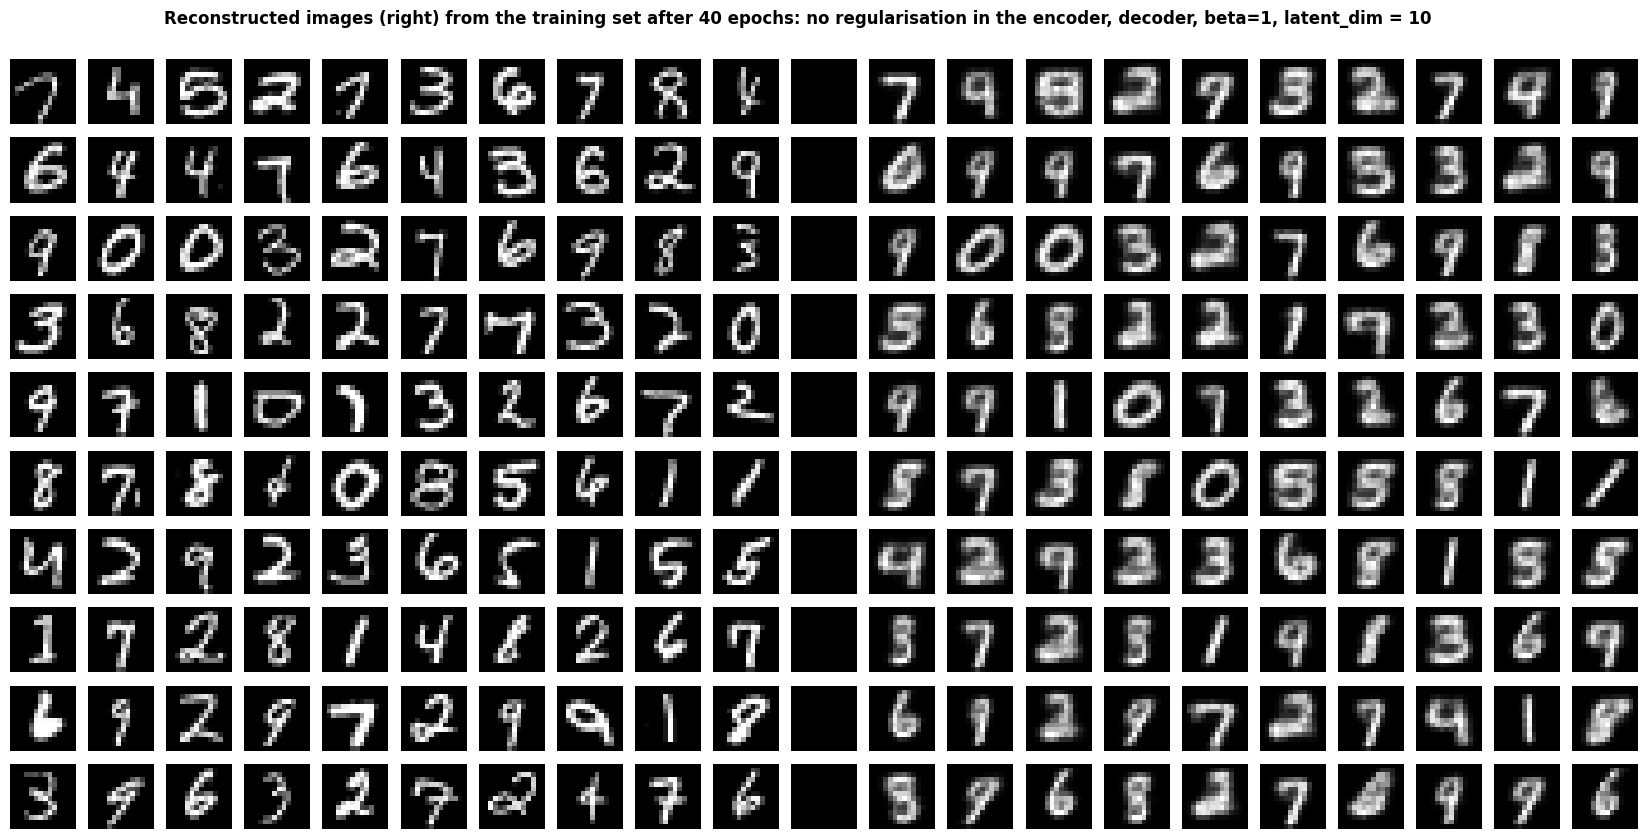

In [47]:
_,_,z_train_sample = encoder(img_train_sample)
img_recon_train = decoder(z_train_sample)

digits_train_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_train_recon.suptitle('Reconstructed images (right) from the training set after 40 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_train_recon.tight_layout()

for i in range(210):
  digits_train_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_train[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

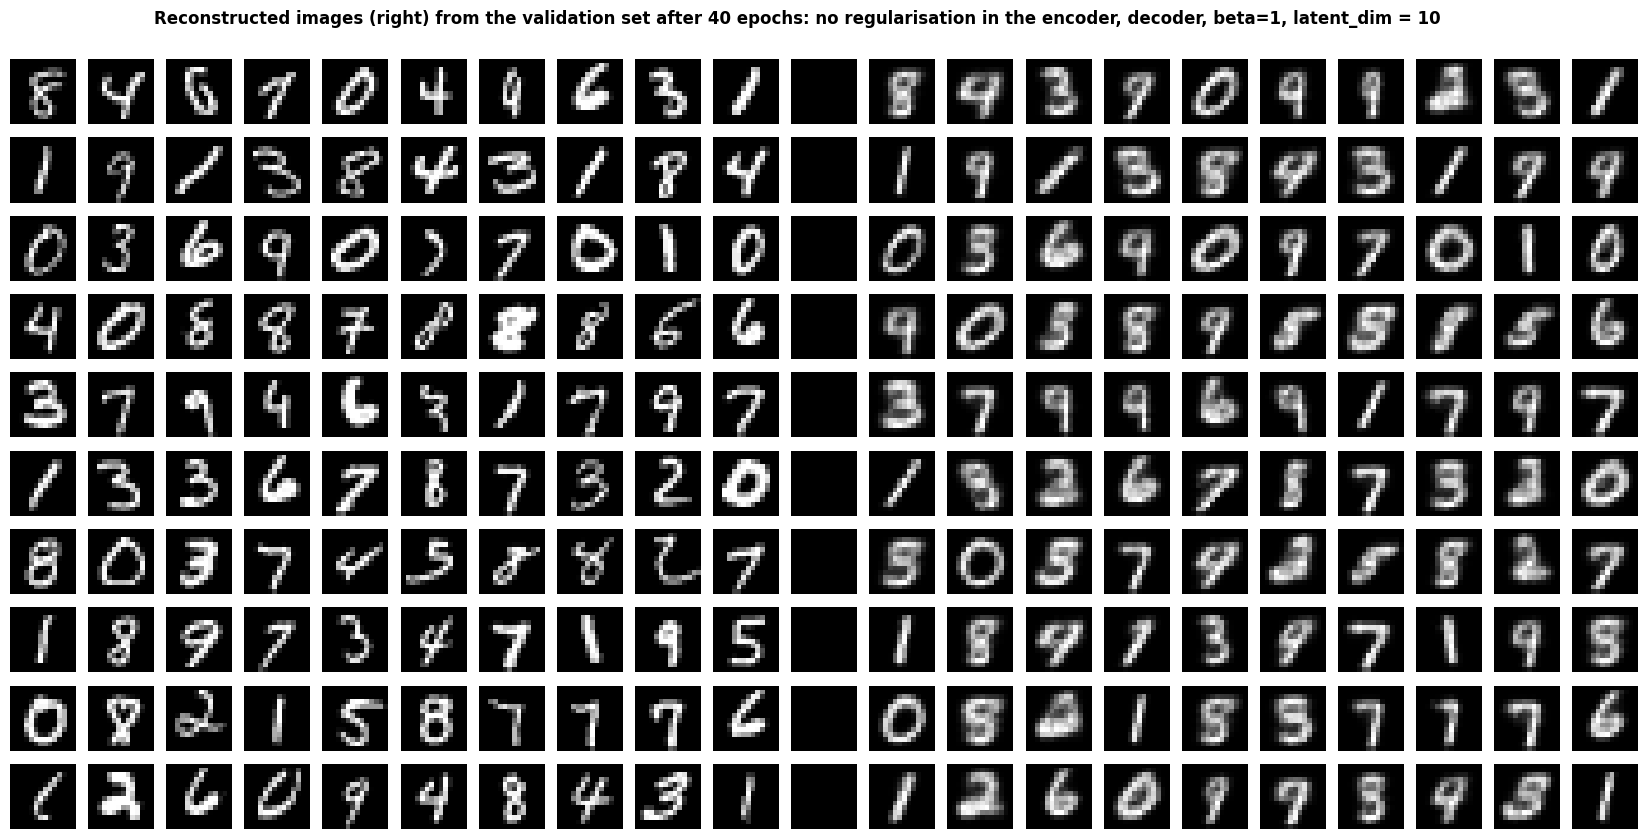

In [48]:
_,_,z_valid_sample = encoder(img_valid_sample)
img_recon_valid = decoder(z_valid_sample)

digits_valid_recon = plt.figure(figsize=(21,10))

digits_valid_recon.suptitle('Reconstructed images (right) from the validation set after 40 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_valid_recon.tight_layout()

for i in range(210):
  digits_valid_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_valid[va_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_valid[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

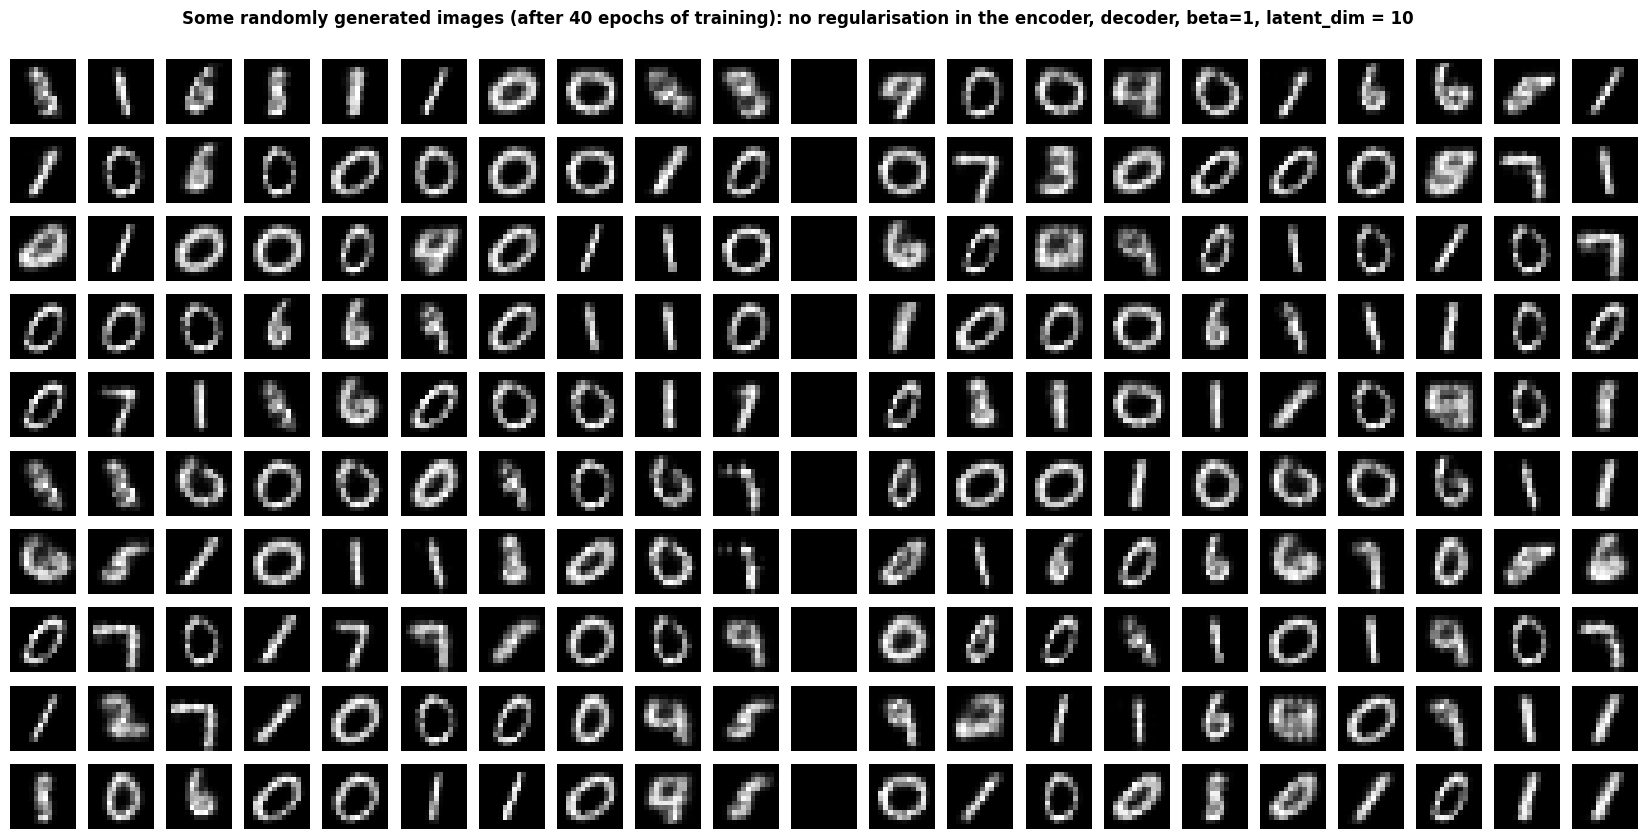

In [49]:
np.random.seed(100)

min_train = min(K.flatten(z_train_sample))
max_train = max(K.flatten(z_train_sample))

min_valid = min(K.flatten(z_valid_sample))
max_valid = max(K.flatten(z_valid_sample))



z_rand_train = tf.convert_to_tensor(min_train + (max_train-min_train)*np.random.random((100,10)))
z_rand_valid = tf.convert_to_tensor(min_valid + (max_valid-min_valid)*np.random.random((100,10)))

img_rand_recon_tr = decoder(z_rand_train)
img_rand_recon_va = decoder(z_rand_valid)

digits_rand_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_rand_recon.suptitle('Some randomly generated images (after 40 epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


for i in range(210):
  digits_rand_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_rand_recon_tr[j*10 + (i%21)]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_rand_recon_va[j*10 + (i%21) - 12]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# **Run even more**

In [50]:
history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, steps_per_epoch=None)

Epoch 1/40
938/938 [==============================] - 16s 17ms/step - loss: 42.6030 - val_loss: 42.5304
Epoch 2/40
938/938 [==============================] - 15s 16ms/step - loss: 42.5500 - val_loss: 42.4259
Epoch 3/40
938/938 [==============================] - 15s 16ms/step - loss: 42.5755 - val_loss: 42.4255
Epoch 4/40
938/938 [==============================] - 15s 16ms/step - loss: 42.5344 - val_loss: 42.5373
Epoch 5/40
938/938 [==============================] - 16s 17ms/step - loss: 42.5019 - val_loss: 42.5138
Epoch 6/40
938/938 [==============================] - 15s 16ms/step - loss: 42.4987 - val_loss: 42.5443
Epoch 7/40
938/938 [==============================] - 15s 16ms/step - loss: 42.4816 - val_loss: 42.4375
Epoch 8/40
938/938 [==============================] - 16s 17ms/step - loss: 42.4505 - val_loss: 42.4950
Epoch 9/40
938/938 [==============================] - 15s 16ms/step - loss: 42.4480 - val_loss: 42.4034
Epoch 10/40
938/938 [==============================] - 15s 16ms/

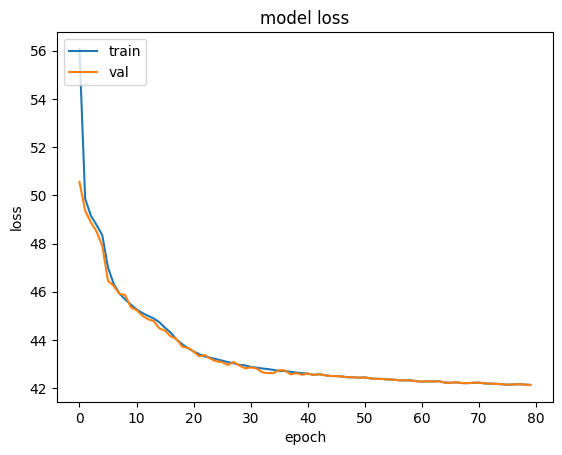

In [52]:
plt.plot(history.history['loss'] + history2.history['loss'] + history4.history['loss'])         # we want to plot the enture learning history so far
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history4.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

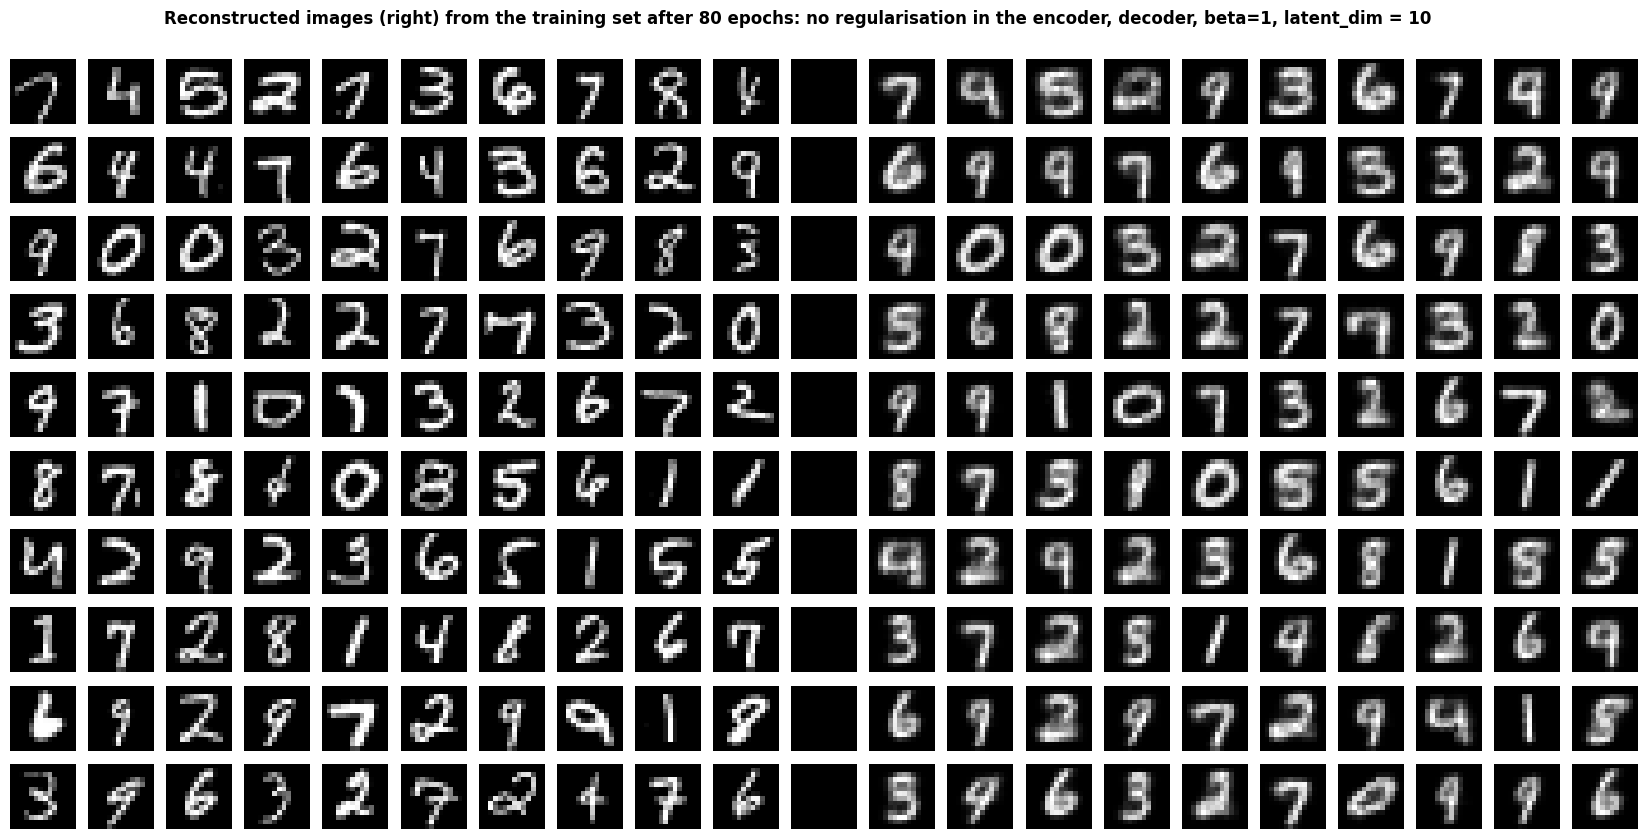

In [53]:
_,_,z_train_sample = encoder(img_train_sample)
img_recon_train = decoder(z_train_sample)

digits_train_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_train_recon.suptitle('Reconstructed images (right) from the training set after 80 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_train_recon.tight_layout()

for i in range(210):
  digits_train_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_train[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

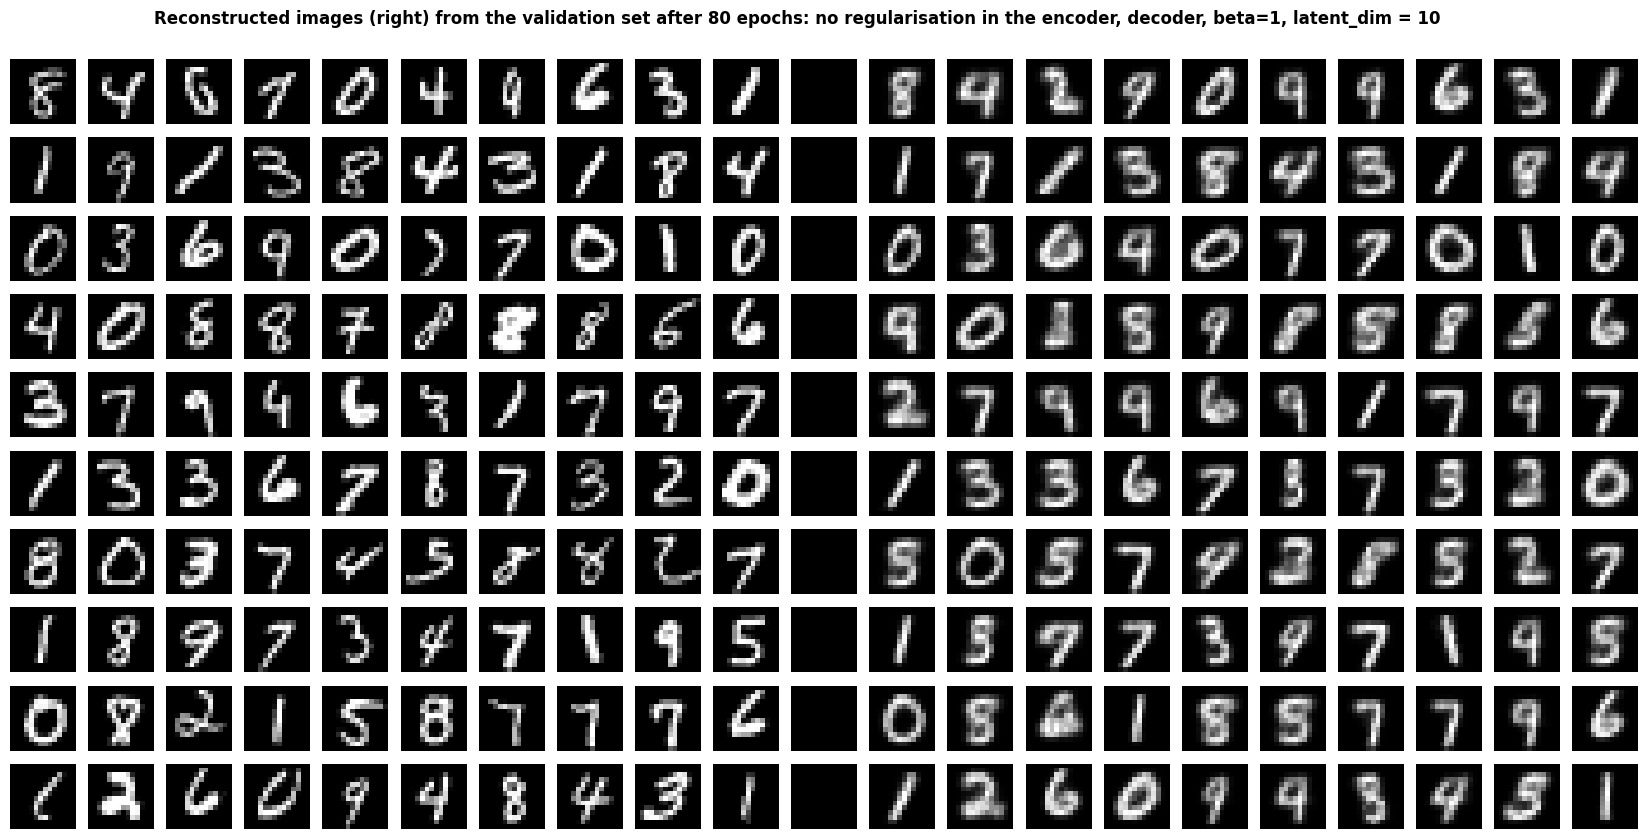

In [54]:
_,_,z_valid_sample = encoder(img_valid_sample)
img_recon_valid = decoder(z_valid_sample)

digits_valid_recon = plt.figure(figsize=(21,10))

digits_valid_recon.suptitle('Reconstructed images (right) from the validation set after 80 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_valid_recon.tight_layout()

for i in range(210):
  digits_valid_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_valid[va_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_valid[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

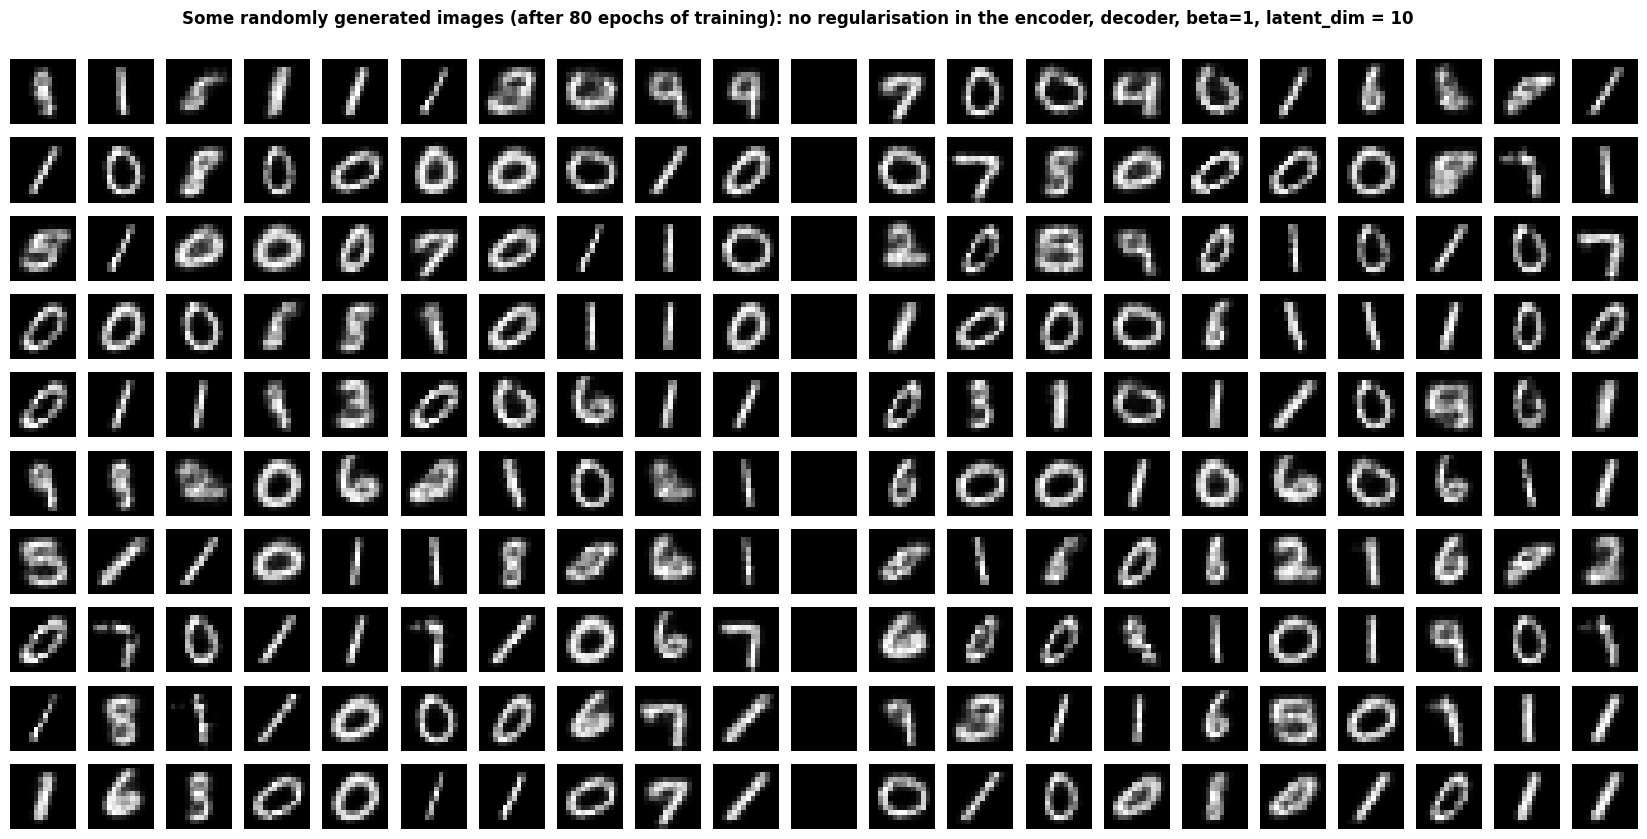

In [55]:
np.random.seed(100)

min_train = min(K.flatten(z_train_sample))
max_train = max(K.flatten(z_train_sample))

min_valid = min(K.flatten(z_valid_sample))
max_valid = max(K.flatten(z_valid_sample))



z_rand_train = tf.convert_to_tensor(min_train + (max_train-min_train)*np.random.random((100,10)))
z_rand_valid = tf.convert_to_tensor(min_valid + (max_valid-min_valid)*np.random.random((100,10)))

img_rand_recon_tr = decoder(z_rand_train)
img_rand_recon_va = decoder(z_rand_valid)

digits_rand_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_rand_recon.suptitle('Some randomly generated images (after 80 epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


for i in range(210):
  digits_rand_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_rand_recon_tr[j*10 + (i%21)]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_rand_recon_va[j*10 + (i%21) - 12]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# **Run even more 2**

In [56]:
history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, steps_per_epoch=None)

Epoch 1/40
938/938 [==============================] - 22s 24ms/step - loss: 42.1327 - val_loss: 42.1599
Epoch 2/40
938/938 [==============================] - 25s 27ms/step - loss: 42.1519 - val_loss: 42.2886
Epoch 3/40
938/938 [==============================] - 16s 17ms/step - loss: 42.1507 - val_loss: 42.1651
Epoch 4/40
938/938 [==============================] - 16s 17ms/step - loss: 42.1354 - val_loss: 42.0127
Epoch 5/40
938/938 [==============================] - 15s 16ms/step - loss: 42.0957 - val_loss: 42.0608
Epoch 6/40
938/938 [==============================] - 16s 17ms/step - loss: 42.0922 - val_loss: 41.9461
Epoch 7/40
938/938 [==============================] - 15s 16ms/step - loss: 42.0936 - val_loss: 42.0899
Epoch 8/40
938/938 [==============================] - 16s 17ms/step - loss: 42.1158 - val_loss: 42.0106
Epoch 9/40
938/938 [==============================] - 17s 18ms/step - loss: 42.0816 - val_loss: 42.0641
Epoch 10/40
938/938 [==============================] - 16s 17ms/

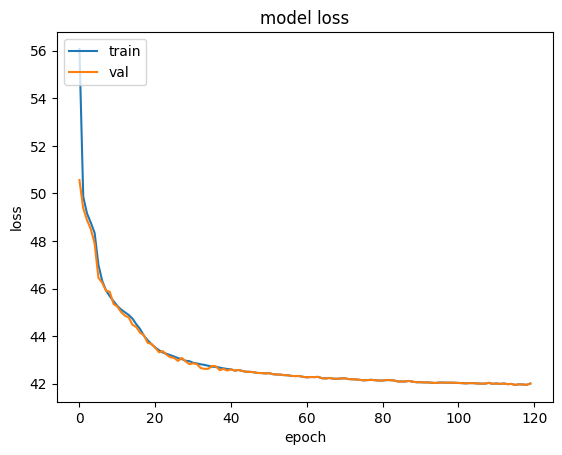

In [57]:
plt.plot(history.history['loss'] + history2.history['loss'] + history4.history['loss'] + history5.history['loss'])         # we want to plot the enture learning history so far
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history4.history['loss'] + history5.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

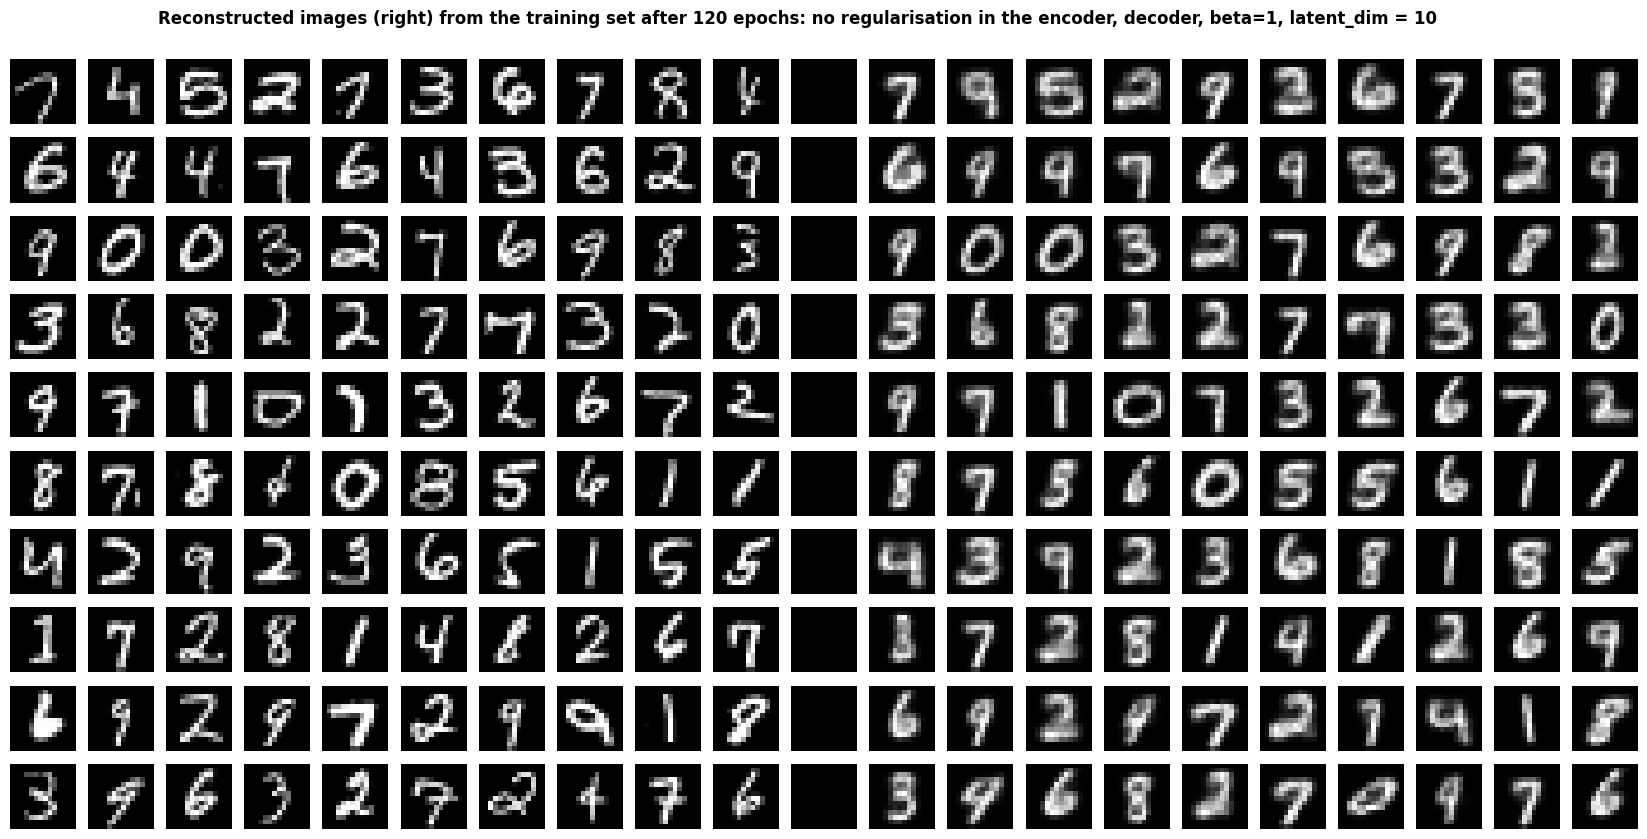

In [61]:
_,_,z_train_sample = encoder(img_train_sample)
img_recon_train = decoder(z_train_sample)

digits_train_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_train_recon.suptitle('Reconstructed images (right) from the training set after 120 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_train_recon.tight_layout()

for i in range(210):
  digits_train_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_train[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

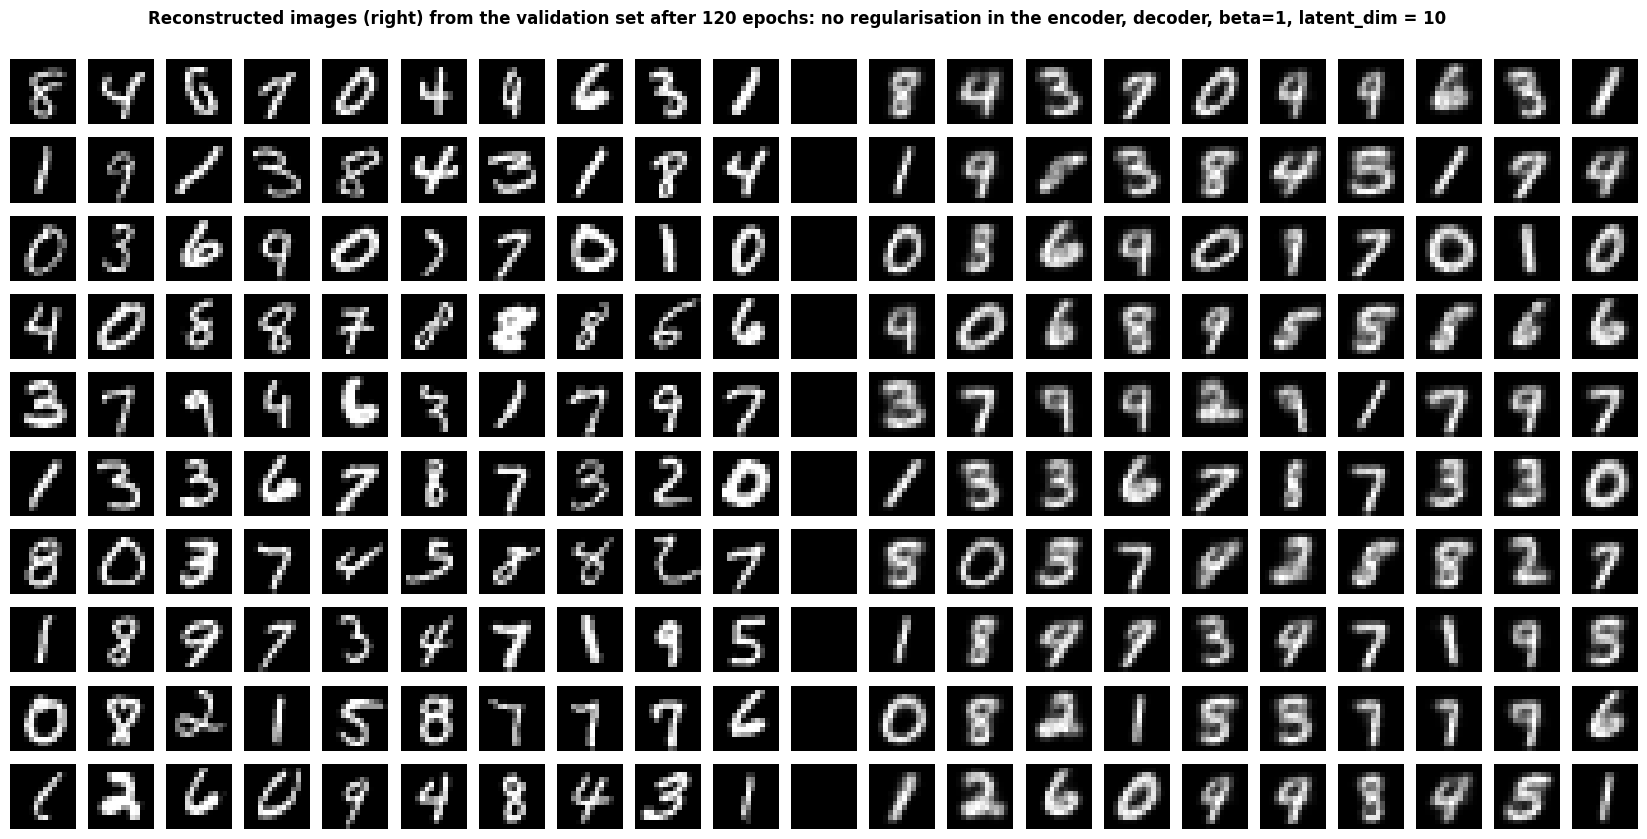

In [59]:
_,_,z_valid_sample = encoder(img_valid_sample)
img_recon_valid = decoder(z_valid_sample)

digits_valid_recon = plt.figure(figsize=(21,10))

digits_valid_recon.suptitle('Reconstructed images (right) from the validation set after 120 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_valid_recon.tight_layout()

for i in range(210):
  digits_valid_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_valid[va_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_valid[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

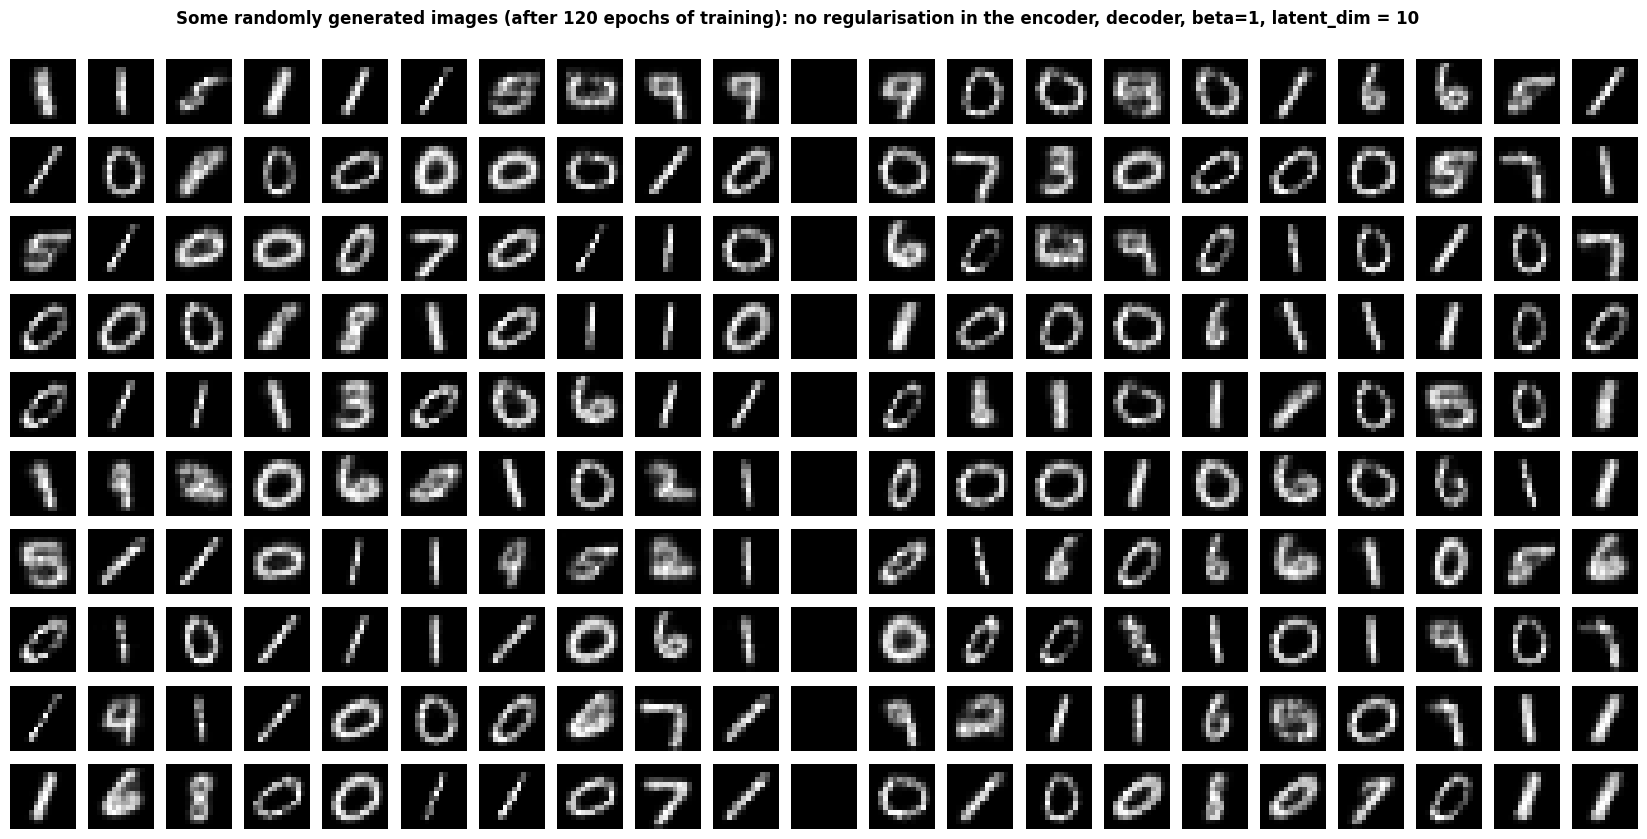

In [60]:
np.random.seed(100)

min_train = min(K.flatten(z_train_sample))
max_train = max(K.flatten(z_train_sample))

min_valid = min(K.flatten(z_valid_sample))
max_valid = max(K.flatten(z_valid_sample))



z_rand_train = tf.convert_to_tensor(min_train + (max_train-min_train)*np.random.random((100,10)))
z_rand_valid = tf.convert_to_tensor(min_valid + (max_valid-min_valid)*np.random.random((100,10)))

img_rand_recon_tr = decoder(z_rand_train)
img_rand_recon_va = decoder(z_rand_valid)

digits_rand_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_rand_recon.suptitle('Some randomly generated images (after 120 epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


for i in range(210):
  digits_rand_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_rand_recon_tr[j*10 + (i%21)]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_rand_recon_va[j*10 + (i%21) - 12]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [75]:
def plot_reconstruction(set, name,seed_val):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 100)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  digits_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after 120 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

  digits_recon.tight_layout()

  for i in range(210):
    digits_recon.add_subplot(10,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')



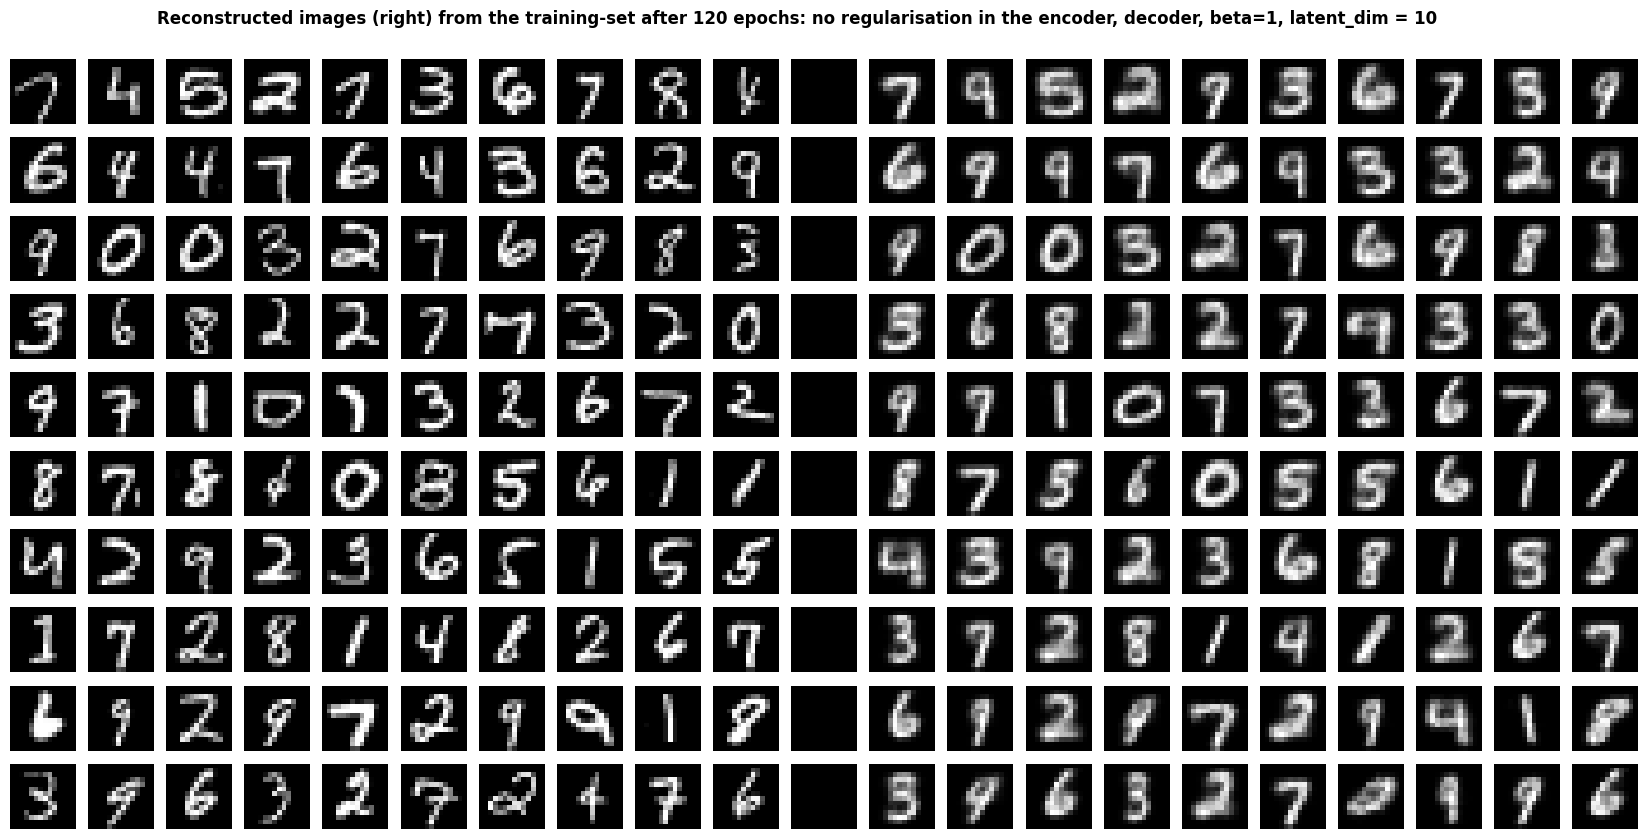

In [76]:
plot_reconstruction(img_train, 'training', 111)